In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from PIL import Image
import cv2
import os

# ✅ Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'
NUM_CLASSES = 6
BATCH_SIZE = 16
NUM_EPOCHS = 15
LR = 1e-4
class_names = ['ANTHRACNOSE', 'DIEBACK', 'GALLMIDEGDAMAGE', 'HEALTHY', 'INSECTDAMAGEWEBBER', 'LEAFBLIGHT']



class ConvertToYCbCr:
    def __call__(self, img):
        return Image.fromarray(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YCrCb))

# ✅ Unified train/eval pipeline
def run_pipeline(color_space):
    print(f"\n============== {color_space} COLOR SPACE ==============")

   
    if color_space == 'YCbCr':
        converter = ConvertToYCbCr()
    else:
        raise ValueError("Unsupported color space")

    # Dummy normalization; replace with dataset mean/std if available
    mean, std = [0.5]*3, [0.5]*3

    transform = transforms.Compose([
        converter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model
    model = models.resnext101_64x4d(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, NUM_CLASSES)
    )
    model = model.to(device)

    # Loss/optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Training
    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            corrects += torch.sum(preds == labels.data)
        train_acc = corrects.double() / len(train_loader.dataset)
        history['train_acc'].append(train_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())

        print(f"[{color_space}] Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Plot Accuracy
    plt.figure()
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title(f'Accuracy - ResNeXt101 ({color_space})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Test Accuracy
    test_accuracy = 100 * correct / total
    print(f"\n✅ Test Accuracy ({color_space}): {test_accuracy:.2f}%")

    # Report
    print(f"\nClassification Report ({color_space}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"Confusion Matrix - ResNeXt101 ({color_space})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# ✅ Run for both color spaces

run_pipeline('YCbCr')



============== YCbCr COLOR SPACE ==============


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:01<00:00, 189MB/s] 


[YCbCr] Epoch 1/15 - Train Acc: 0.9774, Val Acc: 0.9947


Using 2 GPU(s)

============== YCbCr COLOR SPACE ==============


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:04<00:00, 82.8MB/s] 


[YCbCr] Epoch 1/15 - Train Acc: 0.9716, Val Acc: 0.9909
[YCbCr] Epoch 2/15 - Train Acc: 0.9952, Val Acc: 0.9944
[YCbCr] Epoch 3/15 - Train Acc: 0.9962, Val Acc: 0.9931
[YCbCr] Epoch 4/15 - Train Acc: 0.9967, Val Acc: 0.9937
[YCbCr] Epoch 5/15 - Train Acc: 0.9977, Val Acc: 0.9957
[YCbCr] Epoch 6/15 - Train Acc: 0.9979, Val Acc: 0.9946
[YCbCr] Epoch 7/15 - Train Acc: 0.9979, Val Acc: 0.9957
[YCbCr] Epoch 8/15 - Train Acc: 0.9984, Val Acc: 0.9966
[YCbCr] Epoch 9/15 - Train Acc: 0.9982, Val Acc: 0.9959
[YCbCr] Epoch 10/15 - Train Acc: 0.9982, Val Acc: 0.9958
[YCbCr] Epoch 11/15 - Train Acc: 0.9980, Val Acc: 0.9974
[YCbCr] Epoch 12/15 - Train Acc: 0.9992, Val Acc: 0.9964
[YCbCr] Epoch 13/15 - Train Acc: 0.9986, Val Acc: 0.9964
[YCbCr] Epoch 14/15 - Train Acc: 0.9991, Val Acc: 0.9957
[YCbCr] Epoch 15/15 - Train Acc: 0.9988, Val Acc: 0.9975


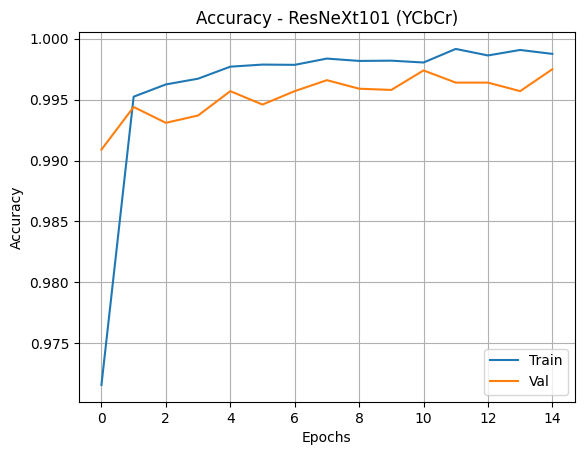


✅ Test Accuracy (YCbCr): 99.65%

Classification Report (YCbCr):
                    precision    recall  f1-score   support

       ANTHRACNOSE       1.00      1.00      1.00      1634
           DIEBACK       1.00      1.00      1.00      1664
   GALLMIDEGDAMAGE       1.00      0.99      0.99      1596
           HEALTHY       1.00      1.00      1.00      1793
INSECTDAMAGEWEBBER       0.99      0.99      0.99      1671
        LEAFBLIGHT       0.99      1.00      1.00      1643

          accuracy                           1.00     10001
         macro avg       1.00      1.00      1.00     10001
      weighted avg       1.00      1.00      1.00     10001



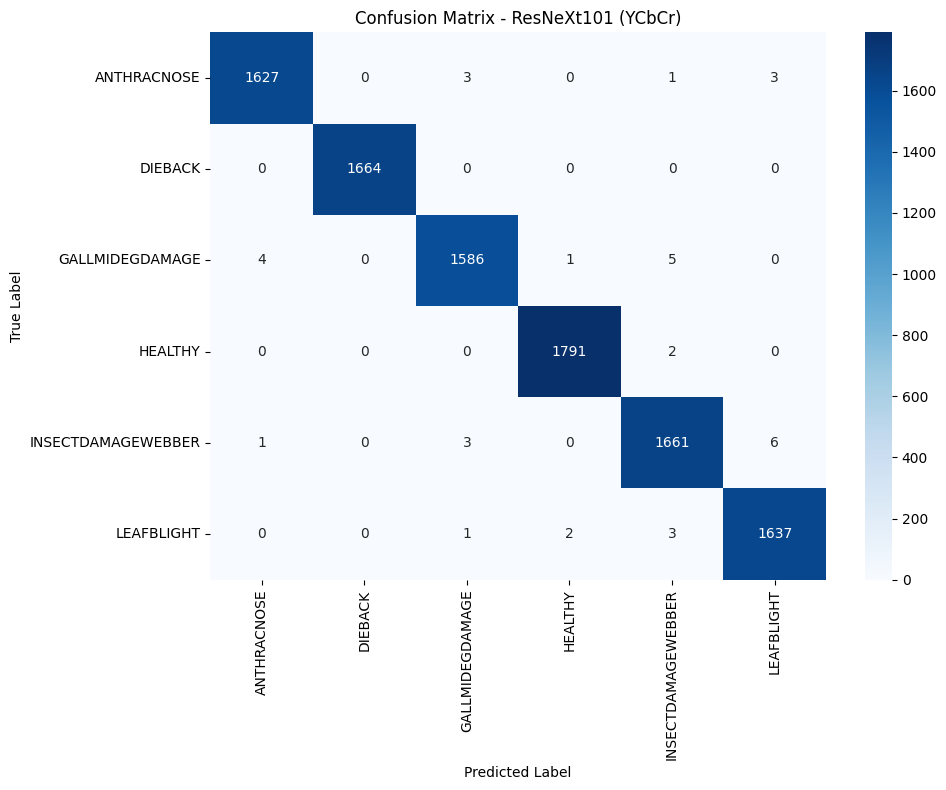

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from PIL import Image
import cv2
import os

# ✅ Device & DataParallel Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_gpu = torch.cuda.device_count() > 1
print(f"Using {torch.cuda.device_count()} GPU(s)")

train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir   = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir  = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

NUM_CLASSES = 6
BATCH_SIZE  = 16 * torch.cuda.device_count()  # scale batch size per GPU
NUM_EPOCHS  = 15
LR = 1e-4

class_names = ['ANTHRACNOSE', 'DIEBACK', 'GALLMIDEGDAMAGE', 'HEALTHY', 'INSECTDAMAGEWEBBER', 'LEAFBLIGHT']

class ConvertToYCbCr:
    def __call__(self, img):
        return Image.fromarray(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YCrCb))

# ✅ Unified train/eval pipeline
def run_pipeline(color_space):
    print(f"\n============== {color_space} COLOR SPACE ==============")

    if color_space == 'YCbCr':
        converter = ConvertToYCbCr()
    else:
        raise ValueError("Unsupported color space")

    mean, std = [0.5] * 3, [0.5] * 3

    transform = transforms.Compose([
        converter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Datasets & Loaders
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
    test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    # ✅ Model Setup
    model = models.resnext101_64x4d(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, NUM_CLASSES)
    )

    if multi_gpu:
        model = nn.DataParallel(model)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # ✅ Training Loop
    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history['val_acc'].append(val_acc)

        print(f"[{color_space}] Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # ✅ Accuracy Plot
    plt.figure()
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title(f'Accuracy - ResNeXt101 ({color_space})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ✅ Evaluation
    model.eval()
    y_true, y_pred = [], []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total
    print(f"\n✅ Test Accuracy ({color_space}): {test_accuracy:.2f}%")

    print(f"\nClassification Report ({color_space}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"Confusion Matrix - ResNeXt101 ({color_space})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# ✅ Run
run_pipeline('YCbCr')
